In [1]:
import torch, torchaudio

In [5]:
import pytorch_lightning as pl

In [6]:
import matplotlib.pyplot as plt

In [7]:
import pandas as pd

In [8]:
from pathlib import Path

In [40]:
from torch import nn

In [ ]:
torch.cuda.is_available()

In [65]:
from torch.nn import functional as F
import torchmetrics as tm

## Step 1: Loading the Data


In [9]:
datapath = Path("data/ESC-50-master")

In [10]:
datapath.exists()

True

In [12]:
csv = pd.read_csv(datapath / Path("meta/esc50.csv"))

In [14]:
csv.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [20]:
x, sr = torchaudio.load(datapath / 'audio' / csv.iloc[0,0], normalize=True)

In [21]:
torchaudio.transforms.Resample(orig_freq=sr, new_freq=8000)(x).shape

torch.Size([1, 40000])

In [22]:
h = torchaudio.transforms.MelSpectrogram(sample_rate=sr)(x)

In [23]:
h.shape

torch.Size([1, 128, 1103])

In [25]:
h = torchaudio.transforms.AmplitudeToDB()(h)

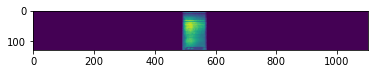

In [26]:
plt.imshow(h[0])

In [30]:
class ESC20Dataset(torch.utils.data.Dataset):
    def __init__(self, path: Path =  Path("data/ESC-50-master"), sample_rate: int = 8000, folds = [1]):
        self.path = path
        self.csv = pd.read_csv(path / Path("meta/esc50.csv"))
        self.csv = self.csv[self.csv['fold'].isin(folds)]
        self.resample = torchaudio.transforms.Resample(orig_freq=44100, new_freq=sample_rate)
        self.melspec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate)
        self.db = torchaudio.transforms.AmplitudeToDB()
    def __getitem__(self, index):
        row = self.csv.iloc[index]
        wav, _ = torchaudio.load(self.path / 'audio' / row['filename'])
        label = row['target']
        xb = self.db(self.melspec(self.resample(wav)))
        return xb, label
    def __len__(self):
        return len(self.csv)
    

In [33]:
train_data = ESC20Dataset()

In [34]:
for xb, yb in train_data:
    break
print(xb.shape)

torch.Size([1, 128, 201])


In [36]:
train_data = ESC20Dataset(folds = [1])
val_data = ESC20Dataset(folds = [2])
test_data = ESC20Dataset(folds = [3])

In [37]:
train_loader = torch.utils.data.DataLoader(train_data,batch_size=8, shuffle=True)

In [38]:
val_loader = torch.utils.data.DataLoader(val_data,batch_size=8)

In [39]:
test_loader = torch.utils.data.DataLoader(test_data,batch_size=8)

## Building Model

In [96]:
class AudioNet(pl.LightningModule):
 
    def __init__(self, n_classes = 50, base_filters = 64):
        super().__init__()
        self.conv1 = nn.Conv2d(1, base_filters, 11, padding=5)
        self.bn1 = nn.BatchNorm2d(base_filters)
        self.conv2 = nn.Conv2d(base_filters, base_filters, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(base_filters)
        self.pool1 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(base_filters, base_filters * 2, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(base_filters * 2)
        self.conv4 = nn.Conv2d(base_filters * 2, base_filters * 4, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(base_filters * 4)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(base_filters * 4, n_classes)
        self.valid_acc = tm.Accuracy()
 
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool1(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool2(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = self.fc1(x[:, :, 0, 0])
        return x
    
    
    def training_step(self, batch, batch_index):
        x,y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat,y)
        self.log('train_loss',loss, on_step = True)
        return loss
    
    def validation_step(self, batch, batch_index):
        x,y = batch
        y_hat = self(x)
        y_hat = torch.argmax(y_hat, dim = 1)
        self.valid_acc(y_hat, y)
        self.log('val_acc',self.valid_acc, on_epoch = True, prog_bar = True)
        return self.valid_acc
    
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = 1e-3)
        return optimizer

In [97]:
pl.seed_everything(0)

Global seed set to 0


0

In [98]:
audionet = AudioNet()

In [99]:
xb, yb = next(iter(train_loader))
audionet(xb).shape

torch.Size([8, 50])

In [100]:
trainer = pl.Trainer(gpus= 1, max_epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [101]:
trainer.fit(audionet,train_loader,val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type        | Params
-------------------------------------------
0  | conv1     | Conv2d      | 7.8 K 
1  | bn1       | BatchNorm2d | 128   
2  | conv2     | Conv2d      | 36.9 K
3  | bn2       | BatchNorm2d | 128   
4  | pool1     | MaxPool2d   | 0     
5  | conv3     | Conv2d      | 73.9 K
6  | bn3       | BatchNorm2d | 256   
7  | conv4     | Conv2d      | 295 K 
8  | bn4       | BatchNorm2d | 512   
9  | pool2     | MaxPool2d   | 0     
10 | fc1       | Linear      | 12.8 K
11 | valid_acc | Accuracy    | 0     
-------------------------------------------
427 K     Trainable params
0         Non-trainable params
427 K     Total params
1.711     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\Users\cecco\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 0
C:\Users\cecco\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [102]:
trainer.test(audionet,test_loader)

C:\Users\cecco\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:99: UserWarning: you passed in a test_dataloader but have no test_step. Skipping test loop
  rank_zero_warn(f"you passed in a {loader_name} but have no {step_name}. Skipping {stage} loop")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[]